# Natural Language Processing Assignment 2B: The Notebook

This is the notebook for the second hand-in assignment for Natural Language Processing. The notebook counts for 65% of the total assignment, the total assignment counts towards 15% of the final grade.

In this notebook, you will be working on Sentiment Classification over IMDB movie reviews! As usual, you can progress through the notebook from top to bottom. The assignment broadly consists of three parts:

1. Data preparation: where you will learn about the task, and prepare the data to be consumed by your PyTorch model.
2. Model training: where you define the appropriate RNN model and training specifics to train the classifier.
3. Results analysis: where you will inspect the model's learned word embeddings.

## Part 4 (15 points): Data preparation

In this part you will prepare the data from the IMDB 50K dataset, so that it can be processed by a PyTorch LSTM-based recurrent model.

First, some usual imports.

In [1]:
import csv
import re
from collections import Counter
import torch
from torch import Tensor, FloatTensor, LongTensor
from typing import Tuple, List, Callable, Optional
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ozani\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### The Task: Movie Review Classification

The [IMDB 50k dataset](https://ai.stanford.edu/~amaas/data/sentiment/) contains 50000 "highly polar" movie reviews, that come together with a label for their sentiment ('positive' or 'negative'). Let's load in the data and inspect the first entry:

In [2]:
with open('./IMDB Dataset.csv', newline='', encoding='utf-8') as csvfile:
    review_reader = csv.reader(csvfile, delimiter=',', quotechar='"')
    reviews, sentiments = zip(*[r for r in review_reader][1:])
reviews = [r for r in reviews]
sentiments = list(sentiments)
display(reviews[0])
display(sentiments[0])

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

'positive'

### Part 4.1 (2 point):

You can see that the data could contain rather long sequences! We will deviate from the exercises in that we will make use of an internal `torch.nn.Embedding` layer to hold and update word embeddings. This layer will hold a single embedding for each word, so for the sake of fast training this layer shouldn't get too big. Therefore, let's figure out how many words our (so far unprocessed) dataset contains. To warm up, finish the below implementation to figure out how many unique words our data contains.

In [3]:
# 4.1 Solution:

def count_vocab(texts: List[str]) -> int:
    all_words = []
    for review in texts:
        words = review.split()
        all_words.extend(words)
    return len(set(all_words))

display(count_vocab(reviews))

438729

### Part 4.2 (5 points):

Yikes! That's way too many words, so we will definitely need to do some preprocessing. But honestly, even after preprocessing we will still have too many words to cover in our model, unless your computer has a very large working memory ;-)

So our strategy will be twofold: first, we want to preprocess a little bit by lowercasing everything and removing unwanted characters. Then, we want to keep only a fixed number of words for each review. In anticipation of the fact that our model's embedding layer will expect number representations of words, we will have to extract a vocabulary of words that we will represent as integers.

In the code below, the first part has already been implemented: the function `preprocess_string` uses regular expressions to remove unwanted characters, `preprocess_text` lowercases a review text and preprocesses each word.

The bottom part was also implemented: the `tensorize_sentences` function will take a list of (preprocessed!) reviews, and a dictionary that maps the words in our vocabulary to integer values for our PyTorch model.

Your job is to complete the implementation of `tokenize_data`. As you can see from the type information, it expects a list of strings (the original reviews), and outputs a pair: a list of processed reviews and the vocabulary map. The processed reviews are already given, but you need to figure out how to create the `word2int` dictionary mapping. It must adhere to the following specifications:

1. It can't contain any stopwords,
2. It must contain exactly 5000 words,
3. It must map to the numbers 1-5000; the number 0 will be reserved for padding of the dataset later on.

In [4]:
# 4.2 Solution:

def preprocess_string(s: str) -> str:
    # Remove all non-word characters (everything except numbers and letters)
    s = re.sub(r"[^\w\s]", '', s)
    # Replace all runs of whitespaces with no space
    s = re.sub(r"\s+", '', s)
    # Replace digits with no space
    s = re.sub(r"\d", '', s)
    return s

def preprocess_text(text: str) -> List[str]:
    return [preprocess_string(word) for word in text.lower().split()]

def tokenize_data(all_texts: List[str]) -> Tuple[List[List[str]], dict[str, int]]:
    processed_reviews = [preprocess_text(s) for s in all_texts]
    stop_words = set(stopwords.words('english'))
    reviews_without_stopwords = []
    for review in processed_reviews:
        reviews_without_stopwords.append([word for word in review if word not in stop_words])
    word_counts = Counter([word for review in reviews_without_stopwords for word in review])
    most_common_words = word_counts.most_common(5000)
    word2int = {word: i for i, (word, _) in enumerate(most_common_words)}
    return processed_reviews, word2int

def tensorize_sentences(preprocessed_texts: List[List[str]], word_map: dict[str, int]) -> List[Tensor]:
    return [torch.tensor([word_map[w] for w in s if w in word_map]) for s in preprocessed_texts]

def tensorize_sentiments(sentiments: List[str]) -> Tensor:
    return [torch.tensor(1.) if sentiment == 'positive' else torch.tensor(0.) for sentiment in sentiments]

Verify your implementation above by running the code below to preprocess and tokenize everything. Then run the code below that to inspect the result for the first review.

In [5]:
processed_reviews, word2int = tokenize_data(reviews)
tokenized_reviews = tensorize_sentences(processed_reviews, word2int)
sentiment_tensors = tensorize_sentiments(sentiments)

In [6]:
display(reviews[0])
display(tokenized_reviews[0])
display(sentiment_tensors[0])

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

tensor([   4, 1802,  937,   57,    1, 3136,  283,  350, 3030,  108,  484,  474,
        1997,    0,   20,   58, 3094, 3136,   51,  466,  180,  108,  551,   53,
        1571,   42,   42, 2358, 1337,  275,  466, 3240,  245,  235,    0,  358,
        3136,  234, 2392,  935, 2486, 1240,  420, 4537, 2369, 1076, 2831,  299,
         213, 4904, 3535,  420,  239, 4974, 2315,  224,   35,  127,    0,    8,
          47,  168, 1170,   42,  549,   93,  161,  156,  433, 2846,  699,   85,
        1138, 4170, 2352,  970,  699, 1278,  699,   59,  854,   88,   20,  283,
          44,  105, 3094, 1439, 2072,  287,   47, 1416,  176, 1330, 1117, 3136,
          90,  213, 1949, 1958,  466,  466, 4784, 2814,  379,  505,   15,  142,
          14,  633,  696,  541, 1076,  549,  434,  808, 1857, 1076,  442,   57,
        3136,  101,  302, 3608, 3114,   15, 1080, 3842,  387])

tensor(1.)

### Part 4.3 (8 points):

As usual, we will have to split up our data and wrap it inside `Dataset`s and `DataLoader`s. While the splitting function and the `ReviewDataset` implementation are already given, we still need to implement the padding function, that is going to make sure that all sequences are padded before being passed to the model.

However, we need to be *very careful* here. Remember how an RNN performs sequence classification by only processing the *last* hidden state of a sequence? Now imagine that we were to pad sequence by adding $0$s at the end of a sequence: then the model would encounter a bunch of empty values in calculating the final hidden state, and wouldn't exactly learn much. So when implementing the `pad_batch` function below it is important that the padding happens on the left of the sequences.

That is, the output of the padding should be a matrix with dimensions `(seq_len, batch_size)`, so with `seq_len` rows (the length of the longest sequence in the batch), and `batch_size` columns (the number of sequences in one batch). Visually this means that one item in the final `DataLoader` would look something like

```
            tensor([[   0,    0,    0,  ...,    0,    0,    0],
                    [   0,    0,    0,  ...,    0,    0,    0],
                    [   0,    0,    0,  ...,    0,    0,    0],
                    ...,
                    [1694,    4,  394,  ...,   48,   12,  189],
                    [4568, 1564,   82,  ...,   45,    3,   69],
                    [  37,   10, 2348,  ...,   24, 1572,  222]])
```

You are free to implement the function `my_sequence_pad` as you see fit. You could of course use the built-in PyTorch function `pad_sequence`, but this adds the trailing 0's at the end of a sequence, so you'd have to hack around that :-)


In [7]:
# 4.3 Solution:
from torch.utils.data import Dataset, DataLoader
import random

def split_data(data, val_cutoff=0.8, test_cutoff=0.9):
    random.Random(42).shuffle(data)
    train = data[:int(val_cutoff*len(data))]
    val = data[int(val_cutoff*len(data)):int(test_cutoff*len(data))]
    test = data[int(test_cutoff*len(data)):]
    return train, val, test


class ReviewDataset(Dataset):
    def __init__(self, X: List[torch.LongTensor], Y: List[torch.FloatTensor]) -> None:
        super(ReviewDataset, self).__init__()
        self.X = X
        self.Y = Y

    def __len__(self) -> int:
        return len(self.X)

    def __getitem__(self, idx: int) -> Tuple[torch.LongTensor, torch.FloatTensor]:
        return self.X[idx], self.Y[idx]


def my_sequence_pad(sequences: List[LongTensor]) -> LongTensor:
    biggest_sequence_length = max([len(sequence) for sequence in sequences])
    padded_sequences = torch.zeros(len(sequences), biggest_sequence_length, dtype=torch.long)
    for i, sequence in enumerate(sequences):
        padded_sequences[i, -len(sequence):] = sequence
    return padded_sequences


def pad_batch(batch: List[Tuple[LongTensor, FloatTensor]]) -> Tuple[LongTensor, FloatTensor]:
    return my_sequence_pad([sample[0] for sample in batch]), torch.stack([sample[1] for sample in batch])


Again, you can verify that your implementation is correct by first running the cell directly below, and then the testing code below it.

In [8]:
tokenized_reviews_train, tokenized_reviews_val, tokenized_reviews_test = split_data(tokenized_reviews, val_cutoff=0.8, test_cutoff=0.9)
sentiment_train, sentiment_val, sentiment_test = split_data(sentiment_tensors, val_cutoff=0.8, test_cutoff=0.9)

tok_train_dataset = ReviewDataset(tokenized_reviews_train, sentiment_train)
tok_train_dataloader = DataLoader(tok_train_dataset, collate_fn=pad_batch, shuffle=True, batch_size=32)

tok_val_dataset = ReviewDataset(tokenized_reviews_val, sentiment_val)
tok_val_dataloader = DataLoader(tok_val_dataset, collate_fn=pad_batch, shuffle=False, batch_size=32)

tok_test_dataset = ReviewDataset(tokenized_reviews_test, sentiment_test)
tok_test_dataloader = DataLoader(tok_test_dataset, collate_fn=pad_batch, shuffle=False, batch_size=32)

In [9]:
# obtain one batch of training data
for sx, sy in tok_train_dataloader:
    display(sx.shape)
    display(sx)
    display(sy)
    break

torch.Size([32, 432])

tensor([[   0,    0,    0,  ...,   11,   45,   25],
        [   0,    0,    0,  ...,   35,  662, 3943],
        [   0,    0,    0,  ..., 1901, 2028, 1510],
        ...,
        [   0,    0,    0,  ...,   17,  219, 4087],
        [   0,    0,    0,  ...,   27,  983,    9],
        [   0,    0,    0,  ...,   24,   13,  178]])

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0.,
        0., 1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 0., 0., 0.])

## Part 5 (30 points): Model training

So far so good! You are now ready to define the model and the training loop. In this part you will implement the model, figure out the appropriate output activation and loss function, and see the model in action!

### Part 5.1 (14 points): Defining the model

Let's start with the model. Part of the implementation is already given: the `embedding` will hold the word embeddings, and as such will map from the `input_dim` (the vocabulary size) to the `embedding_dim`.

After that, we want to process the embedded sequence with an LSTM layer, and use a Linear layer to process the final hidden state of the sequence. Finally, the output activation is applied to the output.

Implement this model by finishing the code below. Note that the [LSTM layer](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html) will automatically take care of initializing the hidden state vector of the 0th timestep of a sequence, so you don't have to do that yourself.

In [10]:
# 5.1 Solution:

class LSTMSequenceClassifier(torch.nn.Module):

    def __init__(self, input_dim: int, embedding_dim: int, hidden_dim: int, output_dim: int, output_activation):
        super(LSTMSequenceClassifier, self).__init__()

        self.embedding = torch.nn.Embedding(input_dim, embedding_dim)

        self.rnn = torch.nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.h_to_y = torch.nn.Linear(hidden_dim, output_dim)
        self.output_activation = output_activation

    def forward(self, text):
        # text dim: [sentence length, batch size]
        embedded = self.embedding(text)
        # embedded dim: [sentence length, batch size, embedding dim]
        _, (h, _) = self.rnn(embedded)
        output = self.h_to_y(h[-1])
        output = self.output_activation(output)
        return output

Great job! As a reward, here is some free code: it implements the training and evaluation loops, for computing the loss over the training and validation sets, and updating the parameters when training.

In [11]:
def train_batch(network: torch.nn.Module,
                X_batch: LongTensor,
                Y_batch: FloatTensor,
                loss_fn: Callable[[FloatTensor, FloatTensor], FloatTensor],
                optimizer: torch.optim.Optimizer) -> float:
    network.train()

    prediction_batch = network(X_batch)  # forward pass
    batch_loss = loss_fn(prediction_batch.squeeze(), Y_batch)  # loss calculation
    batch_loss.backward()  # gradient computation
    optimizer.step()  # back-propagation
    optimizer.zero_grad()  # gradient reset
    return batch_loss.item()


def train_epoch(network: torch.nn.Module,
                dataloader: DataLoader,
                loss_fn: Callable[[FloatTensor, FloatTensor], FloatTensor],
                optimizer: torch.optim.Optimizer,
                device: str) -> float:

    loss = 0.

    for i, (x_batch, y_batch) in enumerate(tqdm(dataloader)):
        x_batch = x_batch.to(device)  # convert back to your chosen device
        y_batch = y_batch.to(device)
        loss += train_batch(network=network, X_batch=x_batch, Y_batch=y_batch,
                            loss_fn=loss_fn, optimizer=optimizer)
    loss /= (i+1) # divide loss by number of batches for consistency

    return loss

def eval_batch(network: torch.nn.Module,
                X_batch: LongTensor,
                Y_batch: FloatTensor,
                loss_fn: Callable[[FloatTensor, FloatTensor], FloatTensor]) -> float:
    network.eval()

    with torch.no_grad():
        prediction_batch = network(X_batch)  # forward pass
        batch_loss = loss_fn(prediction_batch.squeeze(), Y_batch)  # loss calculation

    return batch_loss.item()

def eval_epoch(network: torch.nn.Module,
                # a list of data points x
                dataloader: DataLoader,
                loss_fn: Callable[[FloatTensor, FloatTensor], FloatTensor],
                device: str) -> float:

    loss = 0.

    for i, (x_batch, y_batch) in enumerate(dataloader):
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        loss += eval_batch(network=network, X_batch=x_batch, Y_batch=y_batch, loss_fn=loss_fn)
    loss /= (i+1)

    return loss

### Part 5.2 (6 points): Output activation, loss function

You are almost ready to start training your model! There are just a few ingredients missing.

First of all, instantiate your model below. Make sure that its `input_dim` has the length of the vocabulary, plus an extra dimension for the padding value. You can pick custom dimensions for the word embeddings and the hidden states. Given that the task is binary classification, define the appropriate output dimension and corresponding output activation function, passed as arguments to the model as well.

Combine the model with the appropriate loss function.

In [12]:
# 5.2 Solution:
input_dim = len(word2int)
hidden_dim = 128
embedding_dim = 128
output_dim = 1
output_activation = torch.nn.Sigmoid()

model = LSTMSequenceClassifier(input_dim, embedding_dim, hidden_dim, output_dim, output_activation)
loss_fn = torch.nn.BCELoss()

### Part 5.3 (6 points): Evaluation metric

The final thing is to compute the accuracy of the model: the number of correct classifications out the total number of items. Finish the implementation below to define an appropriate way of calculating accuracy, given your choices above.

In [13]:
# 5.3 Solution:

def measure_accuracy(network: torch.nn.Module,
                     dataloader: DataLoader,
                     device: str) -> float:
    """
        Given a network, a dataloader and a device, iterates over the
        dataset and returns the network's accuracy.
    """
    correct = 0
    total = 0
    for x_batch, y_batch in dataloader:
        pred = network(x_batch.to(device))
        y_batch = y_batch.to(device)
        binary_pred = (pred >= 0.5).int()
        local_total = y_batch.shape[0]
        local_correct = (binary_pred.squeeze() == y_batch).sum().item()
        correct += local_correct
        total += local_total
    return correct/total

### Part 5.4 (4 points): Putting it all together, testing.

You are so ready to run your model! Execute the code below to train your model for 5 epochs, and observe the validation accuracy, it should be well over 80%. Use the code after it to plot the training and validation loss, as well as the validation accuracies. Then, add your own code to report the accuracy on the test set.

In [14]:
from tqdm import tqdm

NUM_EPOCHS = 5

train_losses = []
val_losses = []
val_accuracies = []

# you can set the device to 'cuda' if you have a GPU-enabled PyTorch installation,
# or to 'mps' if you have an M1 Macbook.
device = 'cuda'

optimizer = torch.optim.AdamW(model.parameters(),lr=0.001)


model.to(device)

for t in range(NUM_EPOCHS):
    model.train()
    train_loss = train_epoch(model, tok_train_dataloader, optimizer=optimizer, loss_fn=loss_fn, device=device)
    val_loss = eval_epoch(model, tok_val_dataloader, loss_fn, device=device)
    val_acc = measure_accuracy(model, tok_val_dataloader, device=device)

    print('Epoch {}'.format(t))
    print(' Training Loss: {}'.format(train_loss))
    print(' Validation Loss: {}'.format(val_loss))
    print(' Validation Accuracy: {}'.format(val_acc))

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

100%|██████████| 1250/1250 [00:06<00:00, 194.10it/s]


Epoch 0
 Training Loss: 0.4658020391821861
 Validation Loss: 0.36672516328514004
 Validation Accuracy: 0.836


100%|██████████| 1250/1250 [00:05<00:00, 211.00it/s]


Epoch 1
 Training Loss: 0.34667885219454764
 Validation Loss: 0.3025022332503158
 Validation Accuracy: 0.8762


100%|██████████| 1250/1250 [00:05<00:00, 211.94it/s]


Epoch 2
 Training Loss: 0.2672346235722303
 Validation Loss: 0.29987961485697207
 Validation Accuracy: 0.8758


100%|██████████| 1250/1250 [00:05<00:00, 209.93it/s]


Epoch 3
 Training Loss: 0.2295999883979559
 Validation Loss: 0.28914494257254203
 Validation Accuracy: 0.8878


100%|██████████| 1250/1250 [00:05<00:00, 211.76it/s]


Epoch 4
 Training Loss: 0.1930501193255186
 Validation Loss: 0.29823914995998335
 Validation Accuracy: 0.8816


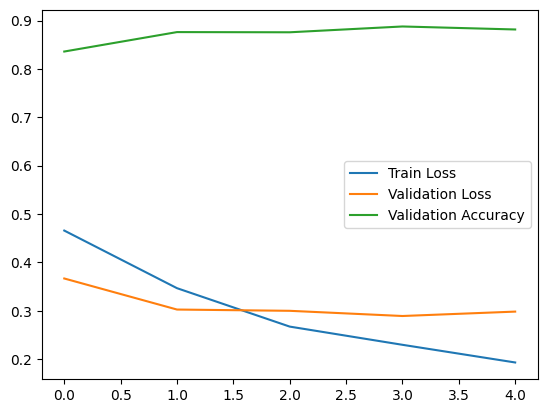

In [15]:
# The code for plotting
from matplotlib import pyplot as plt
plt.plot(train_losses)
plt.plot(val_losses)
plt.plot(val_accuracies)
plt.legend(['Train Loss', 'Validation Loss', 'Validation Accuracy'])
plt.show()

As the very last step of the model training phase, report the accuracy on the test portion of the data.

In [16]:
# 5.4 Solution:
test_loss = eval_epoch(model, tok_test_dataloader, loss_fn, device=device)
test_acc = measure_accuracy(model, tok_test_dataloader, device=device)
print(f'Test loss: {test_loss}')
print(f'Test accuracy: {test_acc}')

Test loss: 0.32945806105994874
Test accuracy: 0.8786


### Part 5.5 (BONUS question): variation in your model

If you feel up for it, experiment with a number of variations on the simple model you implemented.
You can investigate the following suggestions:

   1. Use a stacked LSTM, i.e. where one LSTM feeds into the next etc. Only if you have enough computational power!
   2. Experiment with the dropout parameter (which randomly chooses to *not* update a certain percentage of parameters during training).
   3. Use a bidirectional LSTM.
   4. Replace the Linear output layer with multiple Linear layers.
    
You will receive bonus points for a decent attempt at improvement, as long as you reach equal or higher accuracy compared to the base model.

  0%|          | 0/1250 [00:00<?, ?it/s]

100%|██████████| 1250/1250 [00:12<00:00, 98.66it/s] 


Epoch 0
 Training Loss: 0.5236717072367668
 Validation Loss: 0.3963995961721536
 Validation Accuracy: 0.8294


100%|██████████| 1250/1250 [00:12<00:00, 102.26it/s]


Epoch 1
 Training Loss: 0.344939584672451
 Validation Loss: 0.27751787362774466
 Validation Accuracy: 0.8858


100%|██████████| 1250/1250 [00:12<00:00, 98.29it/s] 


Epoch 2
 Training Loss: 0.28503863268196583
 Validation Loss: 0.2716708882551664
 Validation Accuracy: 0.8898


100%|██████████| 1250/1250 [00:12<00:00, 98.59it/s] 


Epoch 3
 Training Loss: 0.25615950960814954
 Validation Loss: 0.25575917294830275
 Validation Accuracy: 0.8938


100%|██████████| 1250/1250 [00:12<00:00, 97.78it/s] 


Epoch 4
 Training Loss: 0.22906793653070925
 Validation Loss: 0.25800792165812414
 Validation Accuracy: 0.899


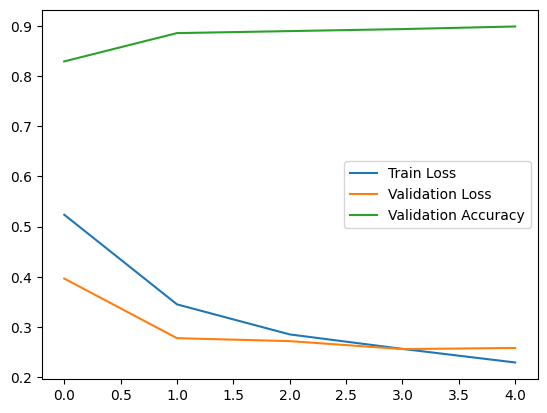

Test loss: 0.2877593339438651
Test accuracy: 0.8832


In [ ]:
# Our model with more stacked layers and dropout added to it

class LSTMSequenceClassifier2(torch.nn.Module):

    def __init__(self, input_dim: int, embedding_dim: int, hidden_dim: int, num_layers, output_dim: int, output_activation, dropout):
        super(LSTMSequenceClassifier2, self).__init__()

        self.embedding = torch.nn.Embedding(input_dim, embedding_dim)
        self.dropout = torch.nn.Dropout(dropout)

        self.rnn = torch.nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.h_to_y = torch.nn.Linear(hidden_dim, output_dim)
        self.output_activation = output_activation

    def forward(self, text):
        # text dim: [sentence length, batch size]
        embedded = self.embedding(text)
        embedded = self.dropout(embedded)
        # embedded dim: [sentence length, batch size, embedding dim]
        _, (h, _) = self.rnn(embedded)
        h = self.dropout(h)
        output = self.h_to_y(h[-1])
        output = self.output_activation(output)
        return output

train_losses = []
val_losses = []
val_accuracies = []

num_layers = 3
dropout = 0.3
model2 = LSTMSequenceClassifier2(input_dim, embedding_dim, hidden_dim, num_layers, output_dim, output_activation, dropout)
optimizer = torch.optim.AdamW(model2.parameters(),lr=0.001)

model2.to(device)

for t in range(NUM_EPOCHS):
    model.train()
    train_loss = train_epoch(model2, tok_train_dataloader, optimizer=optimizer, loss_fn=loss_fn, device=device)
    val_loss = eval_epoch(model2, tok_val_dataloader, loss_fn, device=device)
    val_acc = measure_accuracy(model2, tok_val_dataloader, device=device)

    print('Epoch {}'.format(t))
    print(' Training Loss: {}'.format(train_loss))
    print(' Validation Loss: {}'.format(val_loss))
    print(' Validation Accuracy: {}'.format(val_acc))

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

plt.plot(train_losses)
plt.plot(val_losses)
plt.plot(val_accuracies)
plt.legend(['Train Loss', 'Validation Loss', 'Validation Accuracy'])
plt.show()

test_loss = eval_epoch(model2, tok_test_dataloader, loss_fn, device=device)
test_acc = measure_accuracy(model2, tok_test_dataloader, device=device)
print(f'Test loss: {test_loss}')
print(f'Test accuracy: {test_acc}')

## Part 6 (20 points): Analysis

Now that you have a trained model that works reasonably well, we will investigate the embedding space it has created, along the different word usage in positive and negative reviews.

### Part 6.1 (3 points): Untokenization for data inspection

First, let's take a look at the way words are distributed after tokenization among positive and negative reviews. To do so, we need to untokenize the tokenized reviews. To this end, finish the beneath implementation: it will create the inverted `int2word` map to map the tokenized integer representations of reviews back to the corresponding words, and the subsequent `untokenize` function will take a tokenized review (as a PyTorch Tensor) and produce a list of words.

In [ ]:
# 6.1 Solution:
int2word = {idx: word for word, idx in word2int.items()}

def untokenize(review: Tensor) -> List[str]:
    return [int2word.get(token.item(), '<UNK>') for token in review]

### Part 6.2 (5 points): Positive and Negative vocabularies

Next, we want to look at words that are more specific to the positive and negative reviews. Given the positive and negative tokenized reviews, determine the word frequencies for all positive, and all negative reviews.
Use this to compute the following three items:

1. The words that were among the most common 20 words for the positive ánd negative reviews,
2. The words that occurred more than 1500 times more often in the positive reviews, but not in the list of item '1',
2. The words that occurred more than 2000 times more often in the negative reviews, but not in the list of item '1'.

In [19]:
# 6.2 Solution:
positive_tokenized_reviews = [r for r,s in zip(tokenized_reviews, sentiment_tensors) if s.item() == 1.]
negative_tokenized_reviews = [r for r,s in zip(tokenized_reviews, sentiment_tensors) if s.item() == 0.]

positive_word_counts = {}
negative_word_counts = {}

for review in positive_tokenized_reviews:
    for word in review.tolist():
        positive_word_counts[word] = positive_word_counts.get(word, 0) + 1

for review in negative_tokenized_reviews:
    for word in review.tolist():
        negative_word_counts[word] = negative_word_counts.get(word, 0) + 1

top_20_positive = set(sorted(positive_word_counts, key=positive_word_counts.get, reverse=True)[:20])
top_20_negative = set(sorted(negative_word_counts, key=negative_word_counts.get, reverse=True)[:20])

common_words = top_20_positive & top_20_negative

positive_distinct = {
    word for word in positive_word_counts
    if positive_word_counts[word] > negative_word_counts.get(word, 0) + 1500 and word not in common_words
}

negative_distinct = {
    word for word in negative_word_counts
    if negative_word_counts[word] > positive_word_counts.get(word, 0) + 2000 and word not in common_words
}



In [20]:
print("Common words:", common_words)
print("Distinctly positive words:", positive_distinct)
print("Distinctly negative words:", negative_distinct)

Common words: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13}
Distinctly positive words: {139, 14, 16, 17, 277, 25, 31, 289, 36, 40, 43, 46, 50, 307, 62, 199, 205, 89, 94, 106}
Distinctly negative words: {130, 131, 68, 37, 326, 38, 58, 270, 272, 144, 18, 242, 21, 24, 26, 219, 60, 254}


### Part 6.3 (6 points): Word similarities

The model you trained has internally learnt to represent each word in the vocabulary by an embedding. It is interesting to see how these word embeddings function after learning to do review classification.

We can use PyTorch's internal cosine similarity function to compute the *pairwise* cosine similarities between two matrices: given a matrix $M : W \times D$ and $N: W \times D$, with $W$ the number of words and $D$ the dimensions, the function `similarities` below returns a vector $S: W$ containing the pairwise cosine similarity between the words in $M$ and in $N$ (example: if $M[5]$ represents the word 'great' and $N[5]$ represents the word 'cool', then $S[5]$ holds the cosine similarity between them).

So if we wanted to compute the similarity of one word against a list of other words, we need to stack the vector for the single word to get a matrix of the same size as the matrix containing the embeddings for the other words.

The code below provides the functionality to compute pairwise similarity over two matrices, and a way to retrieve all the embeddings for a list of words. For ease of use the model is placed back on CPU. Run the two cells below to verify that the model contains 5000 embeddings.

In [21]:
model.to('cpu')

def similarities(matrix1: Tensor, matrix2: Tensor):
    return torch.nn.CosineSimilarity(dim=1)(matrix1, matrix2)

def get_vectors(model: LSTMSequenceClassifier, words: List[str], word2int: dict[str, int]):
    return model.embedding(torch.tensor([word2int[word] for word in words]))

In [22]:
all_embeddings = get_vectors(model, list(word2int.keys()), word2int)
display(all_embeddings.shape)

torch.Size([5000, 128])

Now it is your turn. Start by finishing the function `get_similarities_for_word` below. Given a single word and a list of words to compare against, it should return a tensor containing the similarities for the single word against all the other words. You can verify the implementation by running the test code afterwards, which will display the top 10 words for a few examples; of course, the word itself will occur as the most similar!

In [23]:
# 6.3 Solution:

def get_similarities_for_word(word: str, word_list: List[str]) -> Tensor:
    word_vector = get_vectors(model, [word], word2int)
    word_list_vectors = get_vectors(model, word_list, word2int)
    return similarities(word_vector.repeat(len(word_list_vectors), 1), word_list_vectors)

In [24]:
sim_matrix1 = get_similarities_for_word('horrible', list(word2int.keys()))
display([int2word[k.item()+1] for k in sim_matrix1.topk(10).indices])

sim_matrix2 = get_similarities_for_word('awesome', list(word2int.keys()))
display([int2word[k.item()+1] for k in sim_matrix2.topk(10).indices])

['theyre',
 'bible',
 'sons',
 'artists',
 'females',
 'tremendous',
 'murray',
 'elegant',
 'check',
 'image']

['impressive',
 'colorful',
 'description',
 'brand',
 'nowbr',
 'push',
 'wise',
 'defend',
 'passable',
 'towards']

### Part 6.4 (6 points): Closeness of the embedding space

As the very final part, we wish to inspect the average similarity between word lists. Implement the function `get_average_similarities` below, which takes in two lists of words and returns the arithmetic mean of the similarities between them. You should make use of your prior implementation that retrieves similarities for one word against a list of words. Given that you computed overlapping common words, distinctly positive words, and distinctly negative words in 3.2, use your implemtation to calculate the following average similarities:

 1. Between the distinctly positive words and the overlapping common words,
 2. Between the distinctly negative words and the overlapping common words,
 3. Between the distinctly positive words and the distinctly negative word.

In [25]:
# 6.4 Solution:

def get_average_similarities(word_list1: List[str], word_list2: List[str]) -> float:
    word_list1_vectors = get_vectors(model, word_list1, word2int)
    word_list2_vectors = get_vectors(model, word_list2, word2int)
    similarity_scores = similarities(word_list1_vectors.unsqueeze(1), word_list2_vectors.unsqueeze(0))
    return similarity_scores.mean().item()